# Hochschule Bonn-Rhein-Sieg

# Mathematics for Robotics and Control, WS17

# Assignment 2 - Vectors, Matrices, Eigenvalues and Eigenvectors

Before we start with this assignment, let's set up the notebook so that we have all the packages we need for solving the exercises.

In [ ]:
#Group Members
#Swaroop Bhandary K
#Vajra GaneshKumar
#Supriya Vadiraj

In [2]:
try:
    shell = get_ipython()
    shell.enable_pylab('inline')
except NameError:
    pass

import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
import IPython

**Hint**: Before you start solving the assignment, you might want to check out the following *numpy* functions:

```
linalg.eig
linalg.eigh
np.argmax
np.argmin
np.argsort
np.cov
np.mean
np.where
np.einsum
```

## Placing a package [55 points]

This exercise is concerned with matrices, particularly their eigenvalues and eigenvectors, such that our robot will have the task of bringing a package to a conference room and placing it on a flat surface (e.g. a table). 

As you know from the previous assignment, the robot has already picked up a package and is now on its way to the office depicted below.

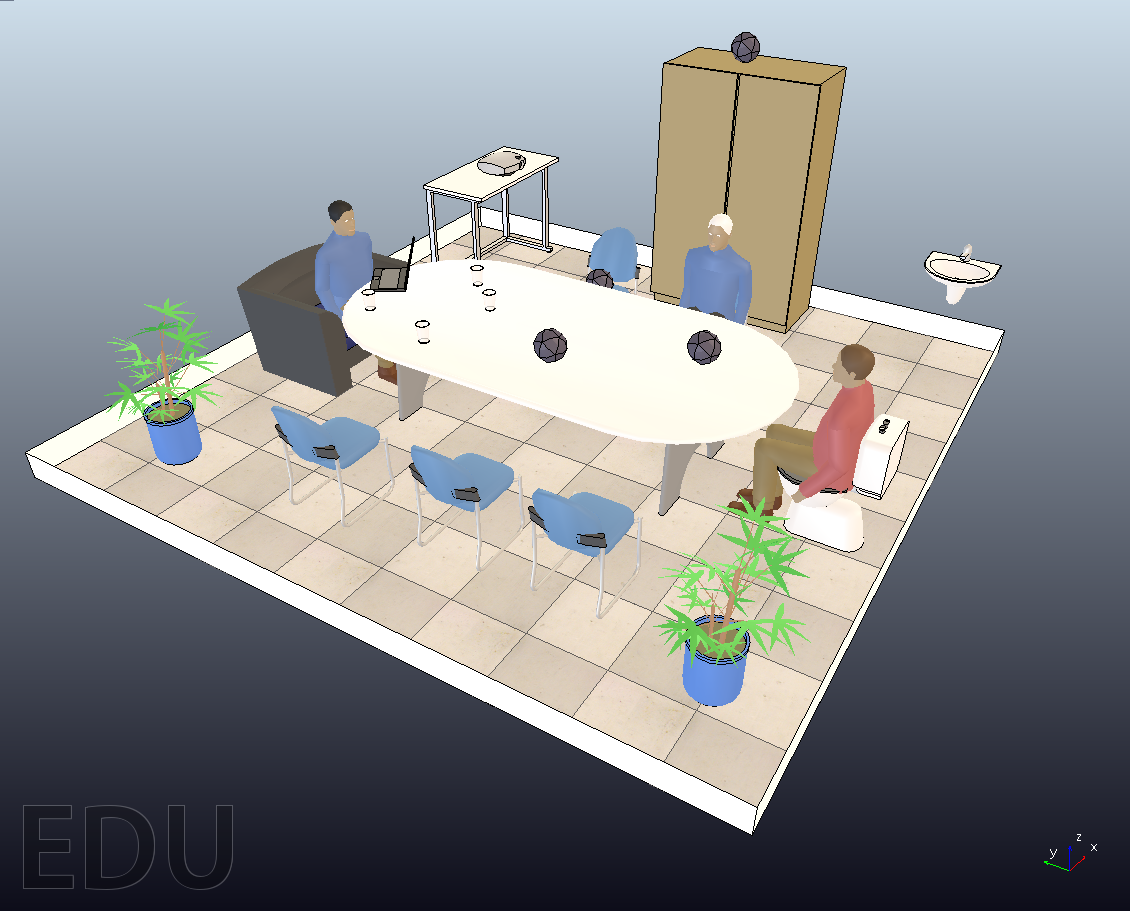

In [2]:
IPython.display.Image("images/isoview.png", width=800, embed=True)

The offices in the building are equipped with sensors that help the robot obtain the required data for carrying out its tasks. The office to which the robot is going now has an RGB-D sensor - a [Microsoft Kinect](https://en.wikipedia.org/wiki/Kinect) - mounted on the ceiling. RGB-D sensors can be used to obtain both a regular color image of a scene and what is called a depth image, in which each pixel encodes distances to the camera's sensor; these distances are typically given with respect to a reference frame whose origin is at the location of the camera's sensor.

Both images obtained in the office are depicted below. Note that darker blue colors in the depth image represent pixels that are farther away from the sensor.

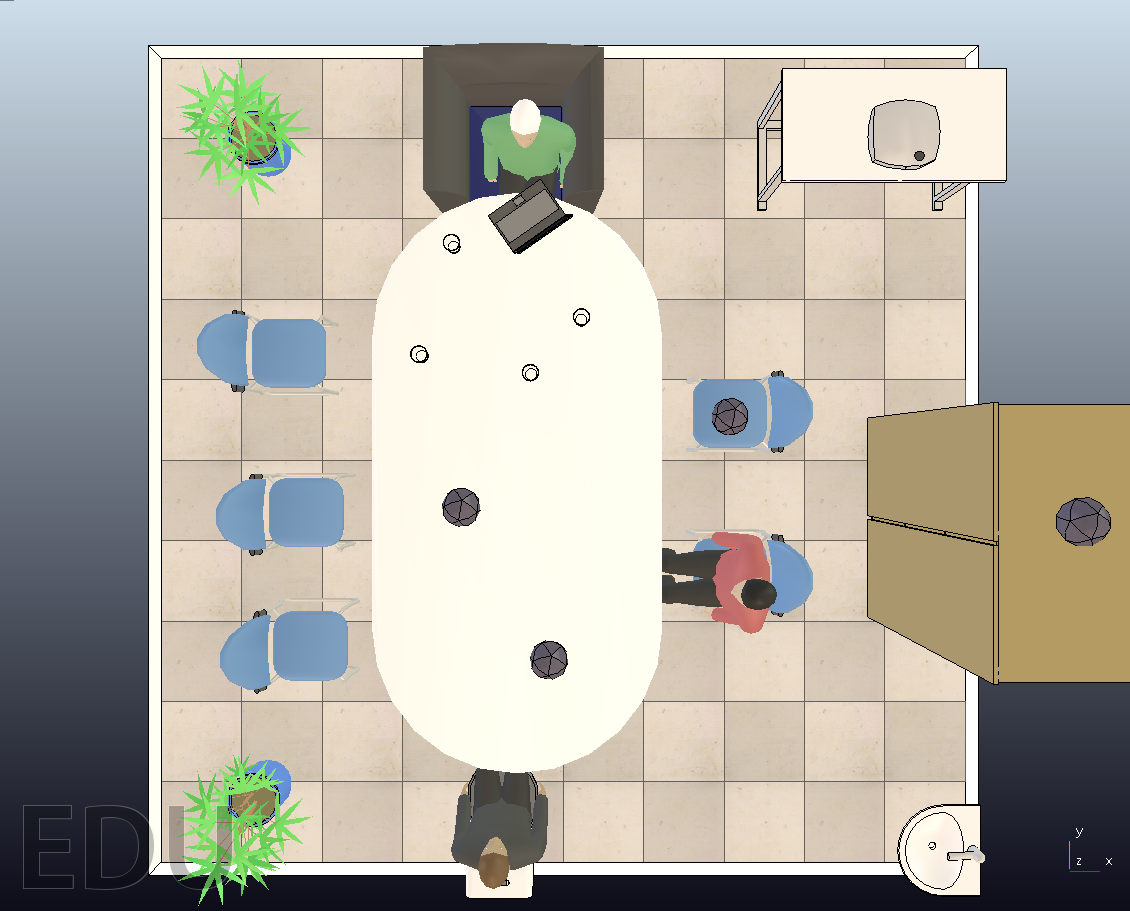

In [3]:
IPython.display.Image("images/rgb.png", width=800, embed=True)

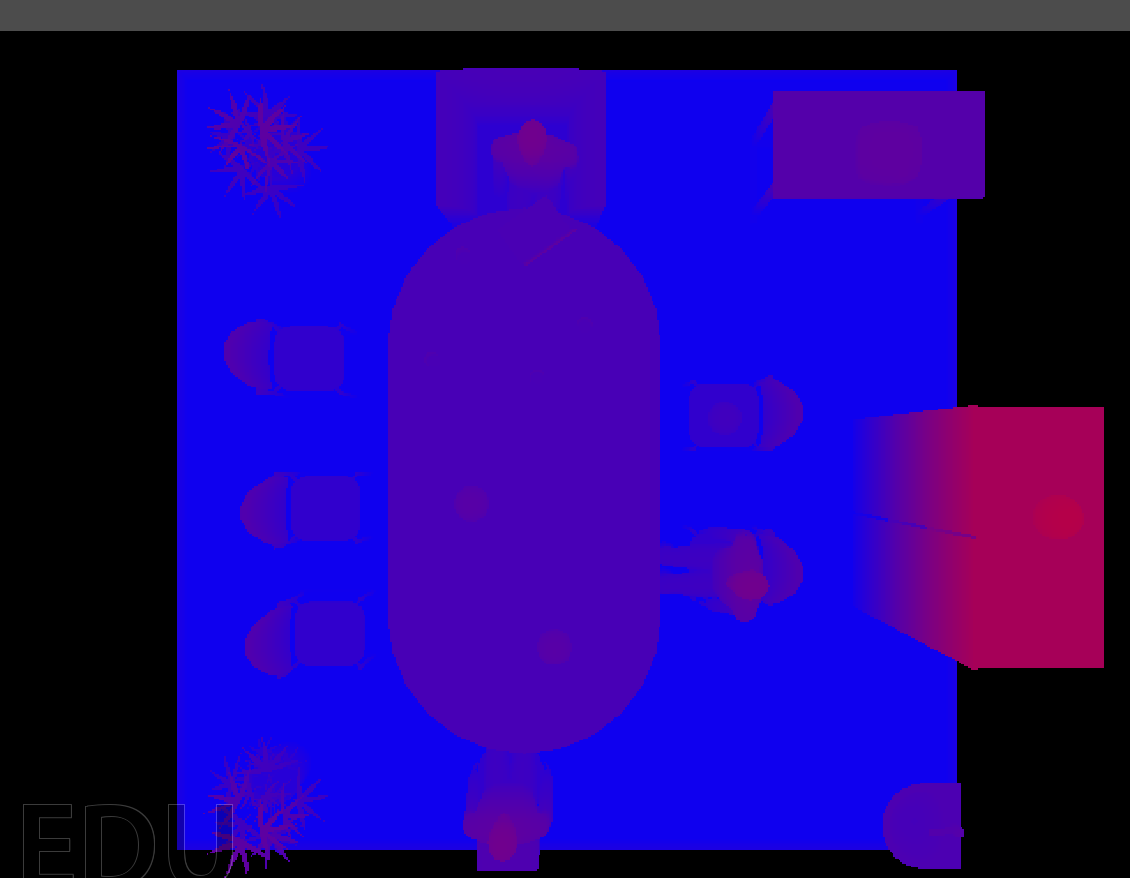

In [4]:
IPython.display.Image("images/depth.png", width=800, embed=True)

Depth images can be converted to a different data format, called a [*point cloud*](http://en.wikipedia.org/wiki/Point_cloud). A point cloud is a collection of 3-component tuples in which each component represents the coordinate of a point along a given axis. A formal definition of a point cloud $P$ is given below:

$P = \{ (x, y, z) \lvert x,y,z \in \mathbb{R} \}$

The picture below shows the aforementioned office scene as a point cloud obtained by the sensor mounted on the office's ceiling. Note that the unit of distance in the point cloud is **meters**.

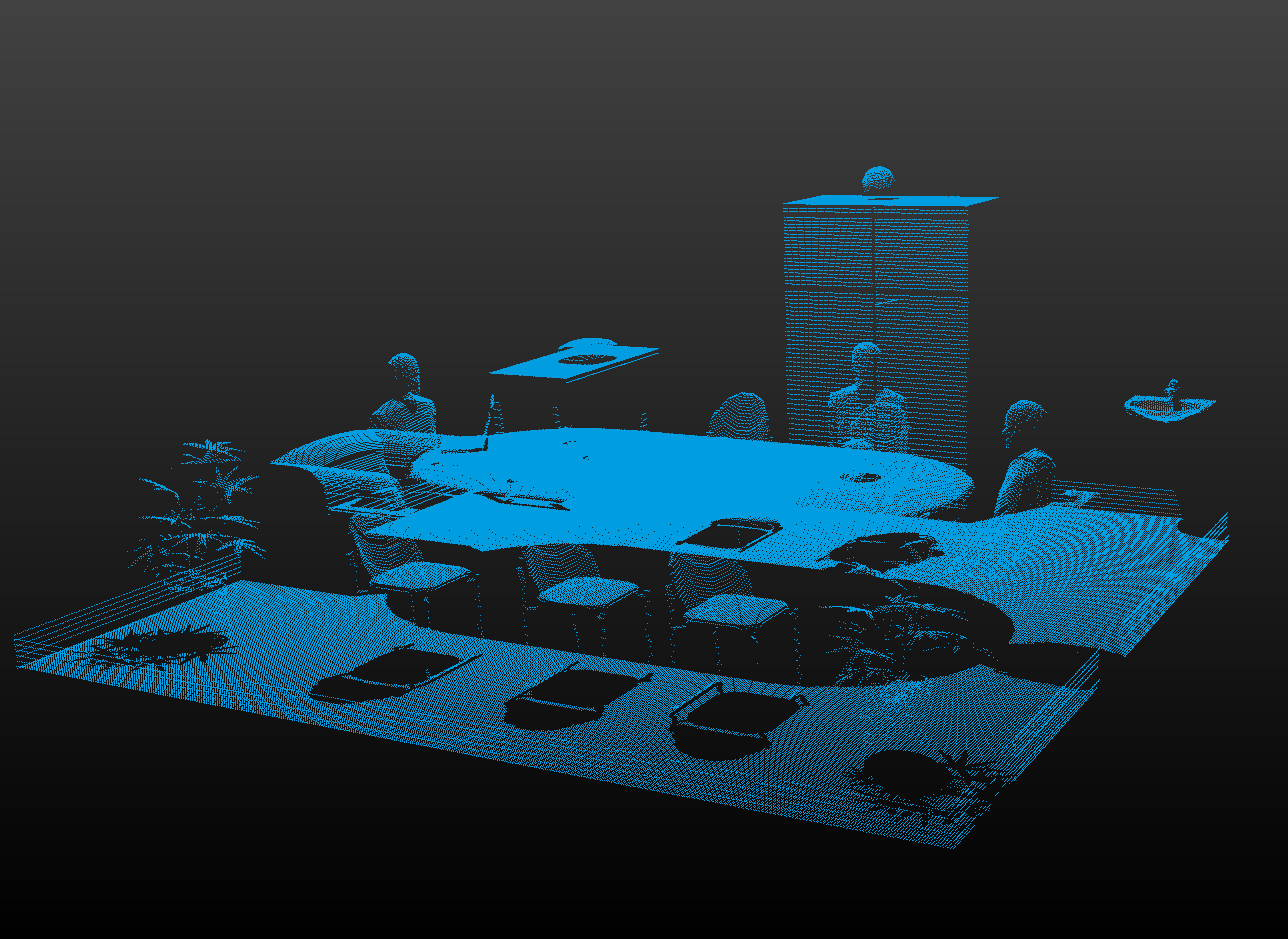

In [5]:
IPython.display.Image("images/pointcloud.png", width=800, embed=True)

If your browser supports WebGL and/or Adobe Flash, you can click [this link](http://www.pointclouds.org/assets/viewer/pcl_viewer.html?load=http://www.directlinkupload.com/uploads/194.95.66.1/cloud.pcd) for observing the point cloud in an interactive manner; otherwise, you can see the included *cloud.asc* or *cloud.ply* file in [MeshLab](http://meshlab.sourceforge.net/), or the included *cloud.pcd* file using *pcl_viewer*, which should be included in your ROS installation.

Notice the object "shadows" in the image above. Given what you know about how the point cloud is generated, think about why these shadows exist and what are they really are.

Now, back to our scenario. Our robot has already reached its destination and is now standing in front of the office door, after requesting sensor data from the central logistics unit and receiving the point cloud. **Your task is to identify possible drop points where the robot could place the package once inside the office**.

### Identifying feasible placement points [45 points]

In order to find feasible drop points for the package, you need to evaluate each point with respect to whether dropping off a package there would make sense; for that purpose, we need to obtain a new point cloud in which each point is associated with a quality measure. A simple quality measure would be the orientation of the [normal vector](https://en.wikipedia.org/wiki/Normal_%28geometry%29) of the underlying surface: given a point, if the surface to which the point belongs is not parallel to the floor, it would probably be unwise to place a package there. Note that normal vectors can be used for detecting tables, shelves and other furniture items commonly used for storing items.

Let us assume that our robot has knowledge of the world reference frame, i.e. it has an understanding of how the world is oriented; this is a reasonable assumption given a fixed robot construction and prior knowledge of the pose of the sensor used to obtain the point cloud data. In this case, we assume that the world frame is a subspace of $\mathbb{R}^3$ and that the orthonormal basis of the coordinate space is

\begin{equation*}
    B = \left\{ \begin{pmatrix}1 & 0 & 0\end{pmatrix}^T, \begin{pmatrix}0 & 1 & 0\end{pmatrix}^T, \begin{pmatrix}0 & 0 & 1\end{pmatrix}^T \right\}
\end{equation*}

To calculate the normal vectors of the points in the point cloud, you will implement a method described in [Surface reconstruction from unorganized points](http://hhoppe.com/recon.pdf), a (rather old) publication by Hoppe et al. You don't have to study the complete paper for implementing this method, as all relevant information is contained in section **3.2 (Tangent Plane Estimation)** of it.

As you will notice by reading this section, we need to find point neighbourhoods (referred to as *Nbhd(x)* in the paper) for calculating the normal vectors. In order to obtain such neighborhoods, we will use [*scipy.spatial.cKDTree*](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html), which is a spatial partitioning structure, and its method *query_ball_point*; we will use a radius of **$4cm$** and the [**L2 norm**](https://en.wikipedia.org/wiki/P-norm#The_p-norm_in_finite_dimensions) as a distance measure when calling this method.

Note: For the purposes of this assignment, you don't necessarily have to understand how a k-d tree works; the only thing you should know about it is that it is a structure that can be used for speeding up spatial neighborhood queries. If you are curious, however, there are many resources on k-d trees available on the web, such as [this collection of k-d tree visualisations](https://www.cs.cmu.edu/~awm/animations/kdtree/).

After obtaining a normal vector of each point's neighborhood, you need to calculate the angle between this normal vector and the $Z$-axis. The reasoning behind this is that a surface has to be parallel to the floor for it to be level; given that every surface parallel to the floor will have a normal vector pointing in the same direction as the $Z$-axis, the angle between the normal vector of the surface and the $Z$-axis is a measure of how level the surface is and shows whether a point is suitable for releasing a package. While performing this step, you need to be careful about points that yield no usable neighborhoods, e.g. points that are too far away from the other points; such points should not be processed. You can pass any value for the resulting angles of these points (except for values that are close to zero, as we will then mistakenly consider the points as being part of a level surface), but do **not** omit them from the final result.

Please implement the desired functionality by filling in the missing code in the cell below.

In [11]:
import scipy.spatial as sp
import math
def rate_placements(point_cloud):
    angles = list()
    ### write your code here ###
    n = point_cloud.size/3
    z = np.array([0,0,1])
    #create kd tree
    kdTree = sp.cKDTree(point_cloud)
    for i in range(n):
        #search for indexes of neighbouring points in kd tree
        neighIndex = kdTree.query_ball_point(point_cloud[i], 0.04)
        #taking points which have more than 20 neigbhouring points else the surface
        #might be too small to hold the package
        if len(neighIndex) > 10:
            #create the neighbourhood point matrix to calculate the covariance
            #each row is new observation and y is the no of dimensions
            neighMatrix = point_cloud[neighIndex[0]]
            for j in range(1,len(neighIndex)):
                neighMatrix = np.vstack((neighMatrix, point_cloud[neighIndex[j]]))
            covarianceMatrix = np.cov(neighMatrix, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eig(covarianceMatrix)
            n_cap = eigenvectors[np.argmin(eigenvalues)]
            angle = np.arccos(np.dot(n_cap,z)/(np.linalg.norm(n_cap)* np.linalg.norm(z)))
            angles.append(np.rad2deg(angle))
        else :
            angles.append(90)
    return angles


point_cloud = np.loadtxt('data/cloud.asc')
angles = rate_placements(point_cloud)
normalised_angles = list()
#1 degree and 179 degree basically are the same. 
#So to remove this affect normalise to a value between 0 to 1
#after this 1 degree and 179 degree will have the same value
for k in range(len(angles)):
    if int(angles[k]) < 90:
        nor_angle = int(angles[k])
    else :
        nor_angle = int(180-angles[k])
    normalised_angles.append(nor_angle)


### Visualising placement points [10 points]

After obtaining the normal vectors of the points in the point cloud, your task is to assign a color to each point by mapping the angles to a linearly segmented color space ranging from green to red, where green means *perfectly parallel to the ground*. You can use the [matplotlib.cm](http://matplotlib.org/api/cm_api.html) module for this task (see [Matplotlib Cookbook: Show Colormaps Example](http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps) for an example of using this module). Generally speaking, this step boils down to picking (or creating) a suitable colormap and applying the colormap to your angle values. Remember to convert the colors to a range of $[0, 255]$ before continuing with the next step.

The following cell shows a simple example on how to create and apply colormaps.

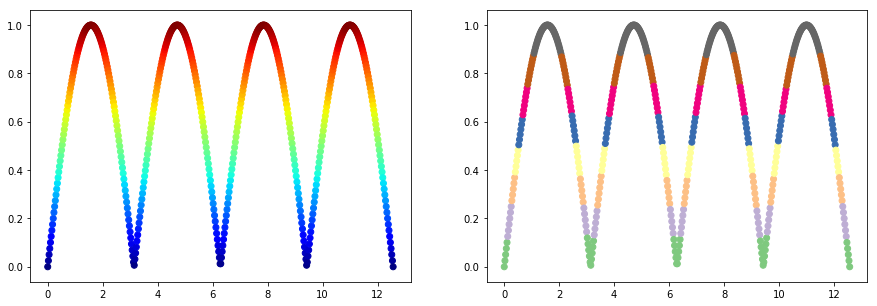

In [5]:
# colormap example
f = plt.figure(figsize=(15, 5))
x = np.linspace(0, 4*np.pi, 500)
y = np.abs(np.sin(x))
plt.subplot(1,2,1)
colors = plt.cm.jet(y)
plt.scatter(x, y, c=colors)
plt.subplot(1,2,2)
colors = plt.cm.Accent(y)
plt.scatter(x, y, c=colors)

Please implement the functionality for mapping the angles to a suitable color space in the cell below.

In [12]:
def color_set(angle3):
    color_matrix = np.array([])
    for index in range(len(angle3)):
        if angle3[index] < 5:
            if index == 0:
                color_matrix = np.array([0,255,0])
            else :
                color_matrix = np.vstack((color_matrix, np.array([0,255,0])))
        elif angle3[index] > 5 and angle3[index] <10:
            if index == 0:
                color_matrix = np.array([0,122,0])
            else :
                color_matrix = np.vstack((color_matrix, np.array([0,122,0]))) 
        elif angle3[index] > 10 and angle3[index] <15:
            if index == 0:
                color_matrix = np.array([0,122,0])
            else :
                color_matrix = np.vstack((color_matrix, np.array([0,122,0]))) 
        else :
            if index == 0:
                color_matrix = np.array([255,0,0])
            else :
                color_matrix = np.vstack((color_matrix, np.array([255,0,0]))) 
    return color_matrix

c1 = color_set(normalised_angles) 

#we tried implementing the below method but it gave variations only 
#between light green and dark green
'''
c = plt.cm.RdYlGn_r(normalised_angles)
c1 = 255*c[:,:3]
'''

After you have obtained color values for each point, create a new $N \times M$ matrix, where $N$ is the number of points, while $M == 6$ corresponds to the $X, Y$ and $Z$ coordinates of each point and its $RGB$ color values (a tuple in the range $[0, 255]$). This matrix will then be passed to the function `save_as_ply`, which generates a file in the [Stanford Triangle Format](https://en.wikipedia.org/wiki/PLY_%28file_format%29). This function is implemented in the `utils.py` script that you have in your assignment directory.

In [13]:
from utils import save_as_ply

### write your code here ###
point_cloud_rgb = np.hstack((point_cloud, c1))
### your code ends here ###

save_as_ply('result.ply', point_cloud_rgb)

You can visualize your generated point cloud file using Meshlab or by using the command line utility **pcl_ply2pcd** and opening the resulting file in **pcl_viewer**. Both utilities come with an installation of PCL and should be included in your ROS installation.

In any case, please generate an image of your solution, name the file `result.png`, place the file inside the `images` directory, and run the cell below to display the result.

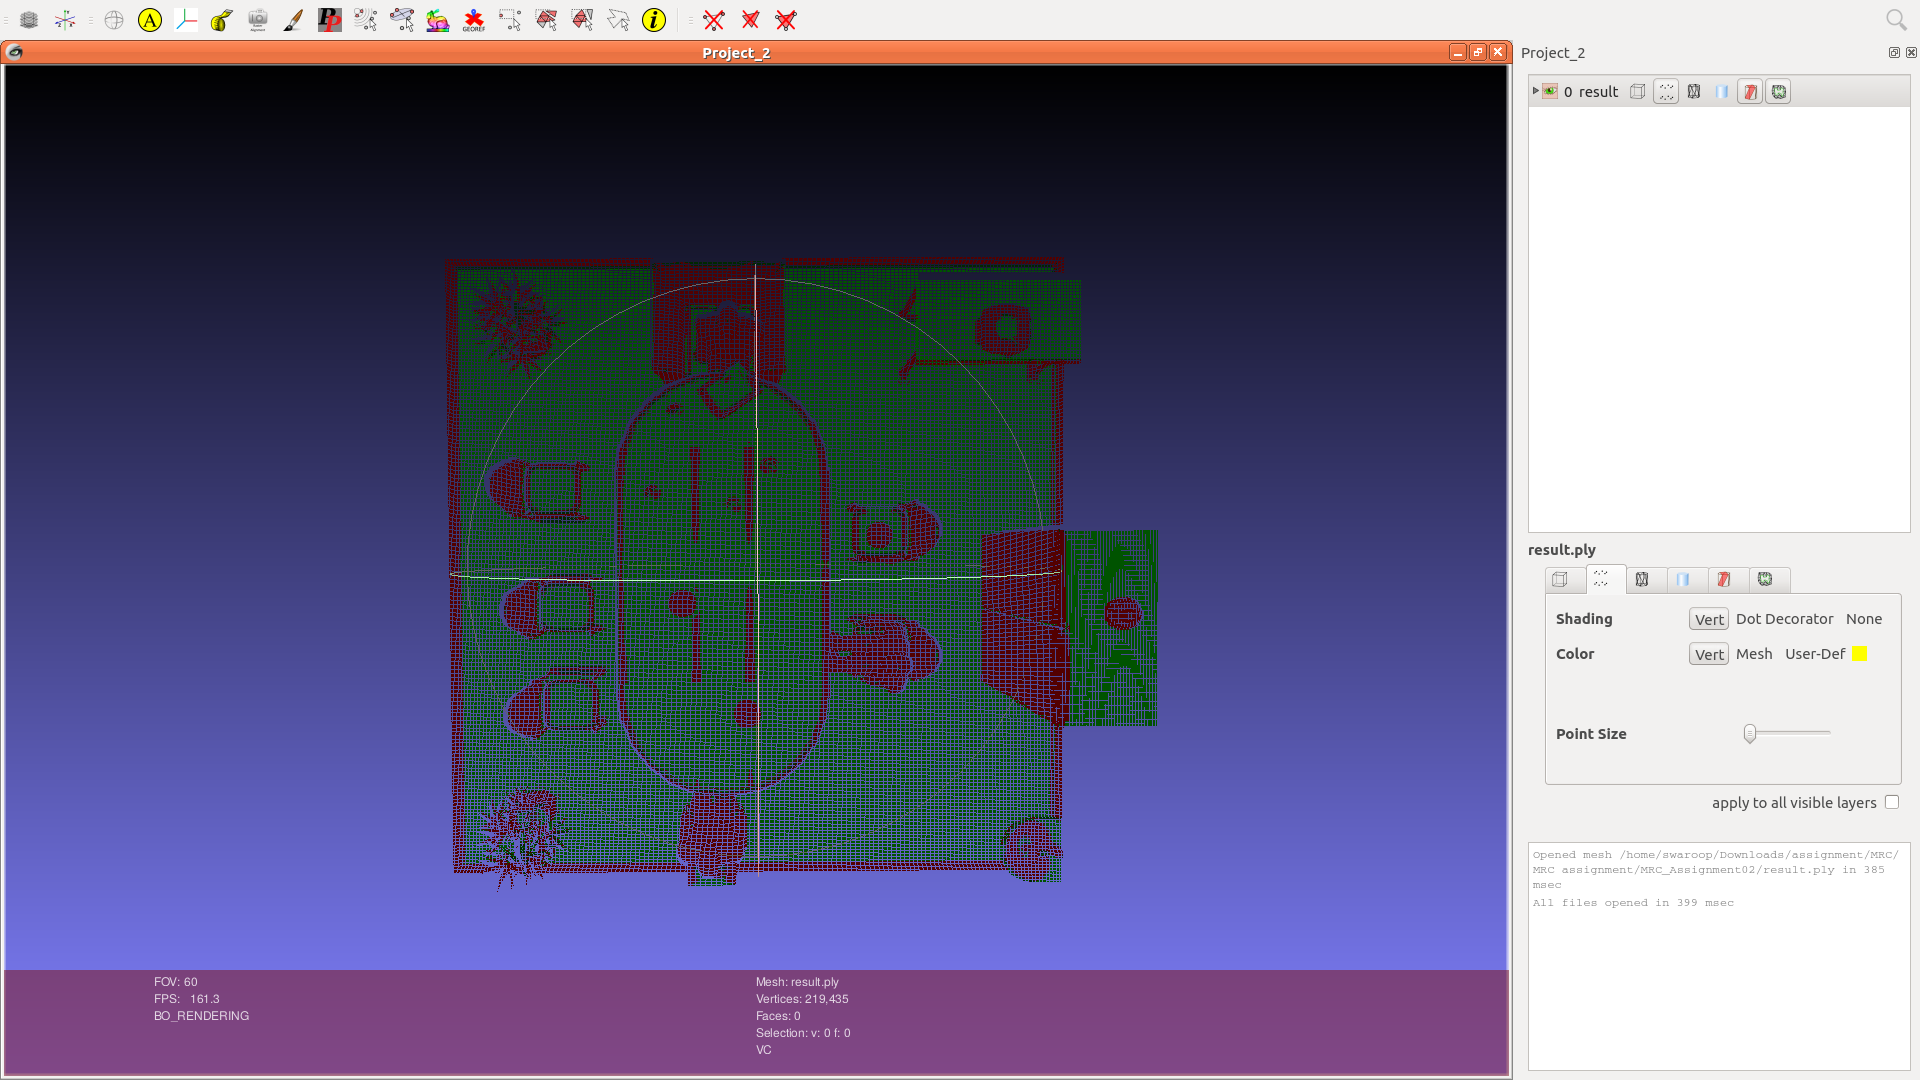

In [14]:
IPython.display.Image('images/result.png', width=800, embed=True)

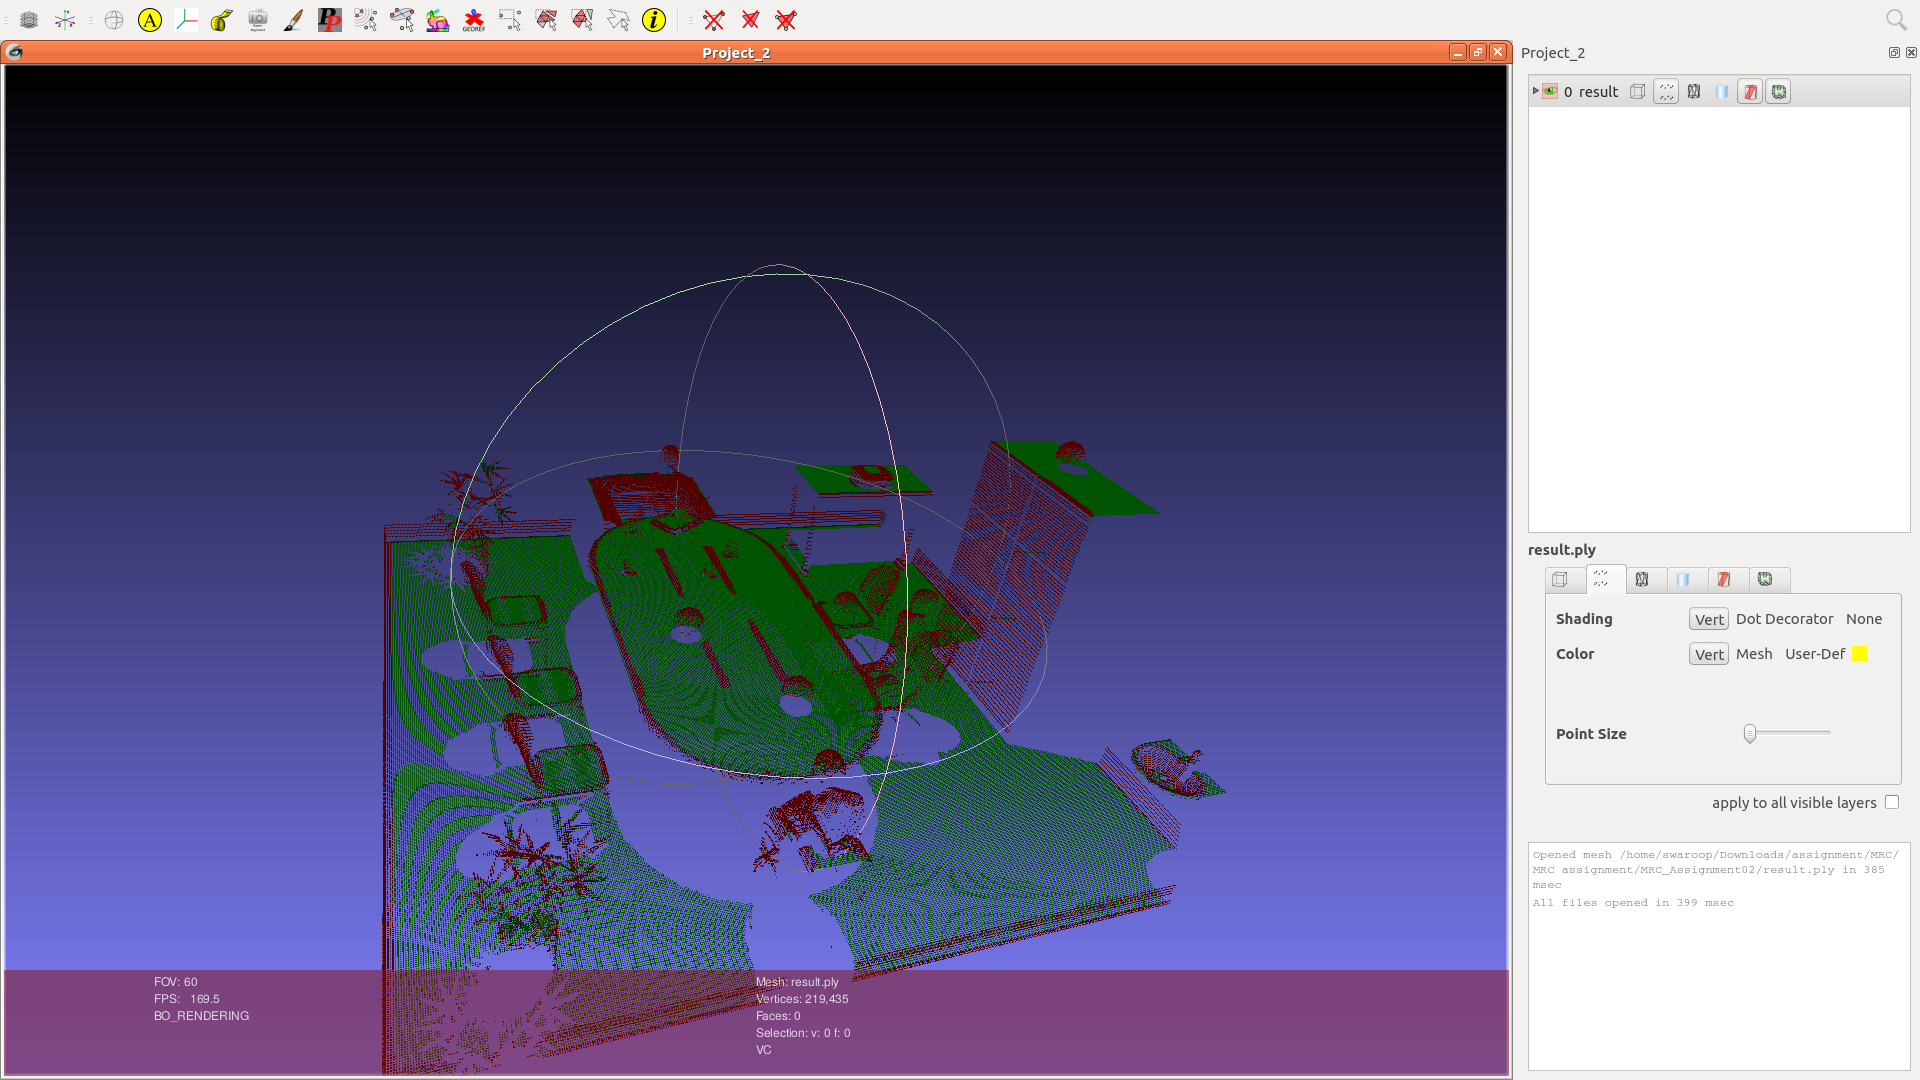

In [16]:
IPython.display.Image('images/result1.png', width=800, embed=True)

Your solution should look similar to the one shown in the image below.

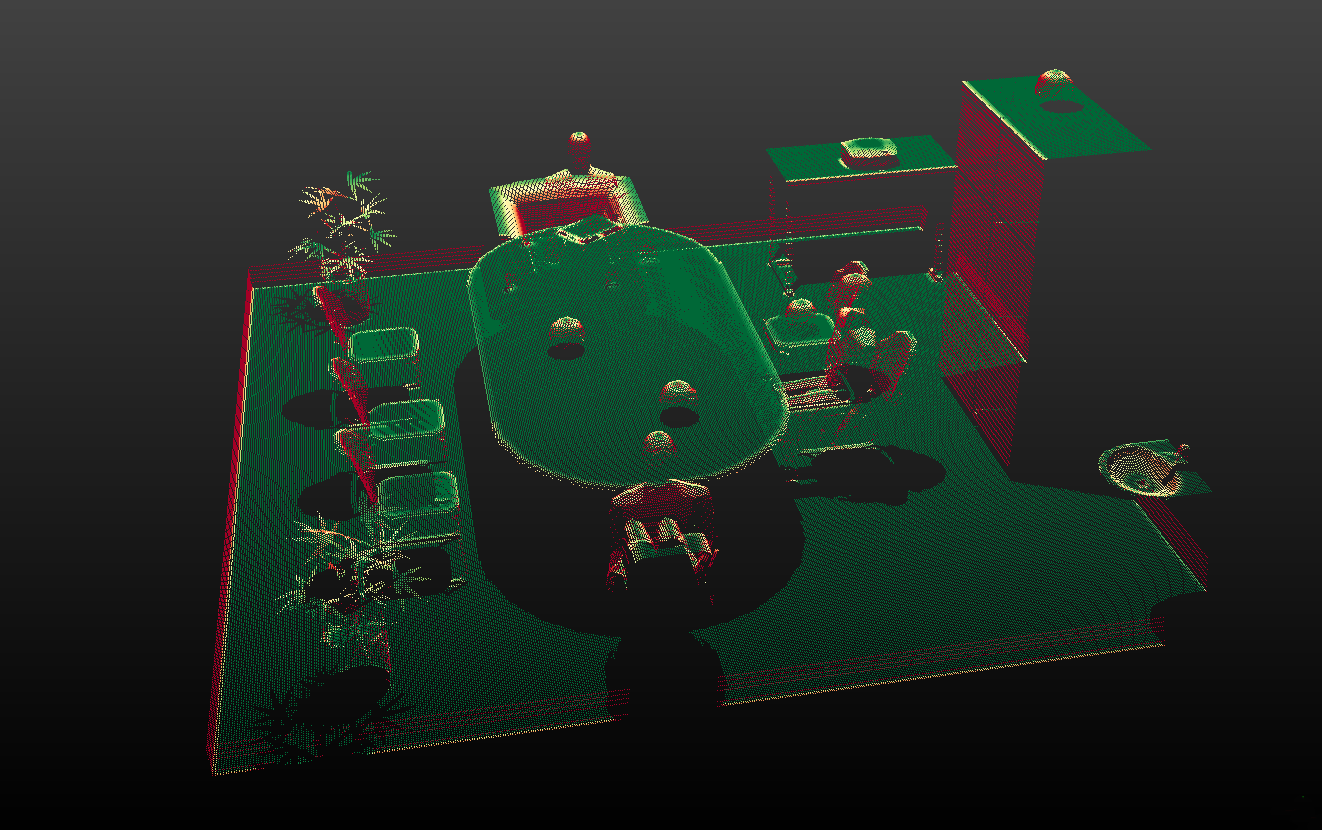

In [7]:
IPython.display.Image('images/sample_result.png', width=800, embed=True)

## Condition number [10 points]

Consider the following set of equations:
$$ 4.5x_1 + 3.1x_2 = 19.249 $$
$$ 1.6x_1 + 1.1x_2 = 6.843 $$

1. Formulate the problem in the form $Ax = B$.
2. Determine whether the problem is ill-conditioned and if yes, try to make it well-conditioned.

In [15]:
#condition number

mat_A = np.array([[4.5,3.1],[1.6,1.1]])

mat_B = np.array([19.249,6.843])

X = np.linalg.solve(mat_A,mat_B)

print 'The value of X1 is:',X[0]

print 'the value of X2 is:',X[1]

#A small change in A can make a small change in B or

#A small change in A can make a big change in B

condition_number = np.linalg.cond(mat_A)

print condition_number

#scaling the initial matrix with a small constant  is equal to 1\condition number

matA_new=mat_A

scale = 1/condition_number

matA_new[1][1]=matA_new[1][1]*scale

X_new = np.linalg.solve(matA_new,mat_B)

print 'The value of X1 is:',X_new[0]

print 'the value of X2 is:',X_new[1]

cn_new=np.linalg.cond(matA_new)

print cn_new



The value of X1 is: 3.94
the value of X2 is: 0.49
3362.99970265
The value of X1 is: 4.27687479798
the value of X2 is: 0.000988196477139
6.38152831654


## Properties of matrices [15 points]

In this exercise, you have to show a few matrix properties that are of particular practical interest.

### Symmetric matrices [5 points]

Show that $A^TA$ is a symmetric matrix.

#### answer ####

Consider a matrix A, to show that the product of its transpose and the matrix itself will be a symmetric matrix. Inorder to prove let us take the transpose of given matrix

<br>$(A^TA)^T$ =$A^T(A^T)^T$

<br>$(A^TA)^T$=$A^TA$

<br>Hence  $A^TA$ is a transpose matrix

<br>



### Orthogonal matrices [5 points]

(G. Strang, "Introduction to Linear Algebra") Assuming that $Q^T = Q^{-1}$, show that the columns $\mathbf{q}_1, ..., \mathbf{q}_n$ are unit vectors, i.e. $\lVert \mathbf{q}_i \rVert^2 = 1$, and that they are perpendicular to each other, i.e. $\mathbf{q}_i^T\mathbf{q}_j = 0$.

#### answer##

Since $Q^{T}$=$Q^{−1}$ , this is a orthogonal matrix.

<br>Q*$Q^{-1}$ = I                      (I = Identity matrix)

<br>Since Q is orthogonal

<br>Q*$Q^T$ = I (identity matrix), i.e, 

<br>$C_1*C_1^T$ = 1 and therefore  $C_i*C_i^T$ = 1 . 

<br>$C_2*C_1^T$ = 0  i.e, $C_i*C_j^T$ = 0 

<br>This implies orthogonal matrix are made of orthonormal vector ie..  $\lVert \mathbf{q}_i \rVert^2 = 1$, and they are perpendicular to each other, i.e. $\mathbf{q}_i^T\mathbf{q}_j = 0$

### Eigenvalues [5 points]

Show that $\lVert A \rVert$ (the determinant of the matrix $A$) is equal to the product of $A$'s eigenvalues $\lambda_1, ..., \lambda_n$.

#### answer ####

Eigenvalues obey the equation |A − λI| = 0.

Eigenvalues are roots of the characteristicdet(A−λIn)

        

                    |a11−λ  a12   .... a1,n |
                    |a21    a22−λ .... a2,n |
         |A − λI| = | :       :   ....   :  | = Product of (λi - λ)
                    | :       :   ....   :  |
                    | an1   an2        ann−λ|
                    

                    

                    

  let λ = 0 then |A| = product of λ1,...,λn

      And therefore the determinant of the matrix A is equal to the product of A's eigenvalues λ1,...,λn

        


